In [315]:
import numpy as np
import GPy
GPy.plotting.change_plotting_library('matplotlib')

import matplotlib.pyplot as plt
from scipy.optimize import minimize


def update_posterior(m, x_new):
    y = sample(x_new)
    X = np.concatenate([m.X, np.array([x_new])])
    Y = np.concatenate([m.Y, np.array([y])])
    m.set_XY(X, Y)
    m.optimize()
    
def ucb(x, m):
    kappa = 2
    mean, std = m.predict(np.array([x]))
    return (mean + kappa * std)[0]

def rand_samples(n_samples, bounds, kernel):
    dim = kernel.input_dim
    return np.random.uniform(bounds[:, 0], bounds[:, 1], size=(n_samples, dim))

def max_acq(ac, m, bounds, n_starts=1000):
    min_y = 1 # TODO:
    min_x = None
    
    min_obj = lambda X: -ac(X, m)

    # TODO: parallelize
    # Find the best optimum by starting from n_restart different random points.
    for x0 in rand_samples(n_starts, bounds, m.kern):
        res = minimize(min_obj, x0=x0, bounds=bounds, method='L-BFGS-B')        
        if res.fun < min_y:
            min_y = res.fun[0]
            min_x = res.x           
            
    return min_x

def bo(f, kernel, bounds, plot=True, n_iter=10):
    x = rand_samples(2, bounds, kernel)
    m = GPy.models.GPRegression(x, f(x), kernel)

    if plot:
        # required to plot aquisition func
        boundedX = np.arange(bounds[:, 0], bounds[:, 1], 0.01).reshape(-1, 1)

    for i in range(0, n_iter):
        xnew = max_acq(ucb, m, bounds=bounds)

        if plot:
            fig = m.plot()
            fig.set_title(f'Iteration {i}')
            GPy.plotting.show(fig, filename='basic_gp_regression_notebook')

            plt.figure()
            acY = np.fromiter((ucb(x,m) for x in boundedX), np.float)
            plt.plot(boundedX, acY, 'r-', lw=1, label='Acquisition function')
            plt.axvline(x=xnew, ls='--', c='k', lw=1, label='Next sampling location')
            plt.show()
            
        update_posterior(m, xnew)

    if plot:
        fig = m.plot()
        fig.set_title(f'Iteration {i+1}')
        GPy.plotting.show(fig, filename='basic_gp_regression_notebook')

 /Users/tmpethick/anaconda3/envs/eth/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


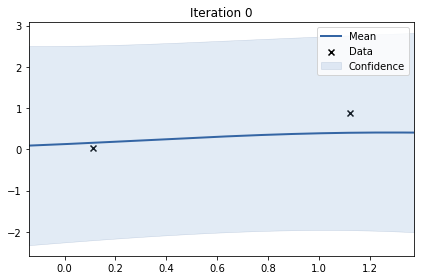

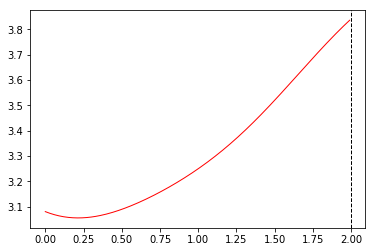

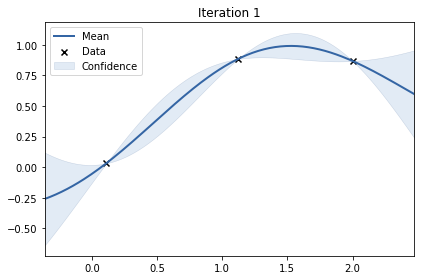

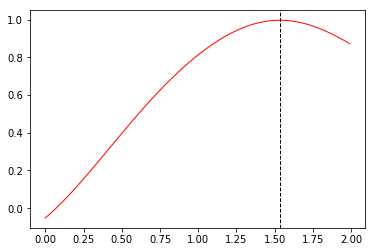

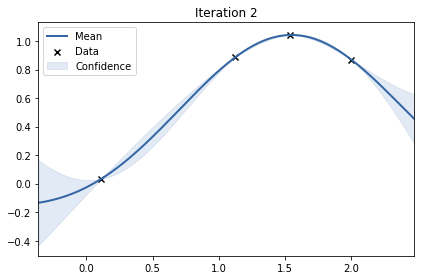

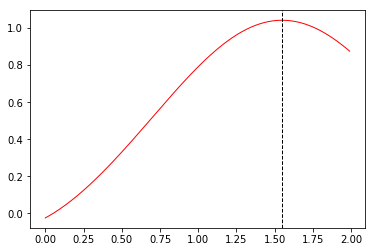

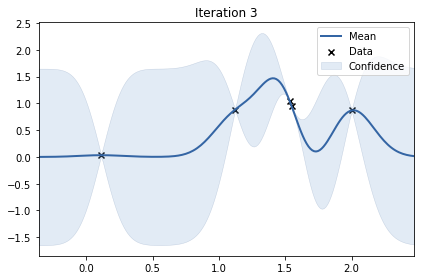

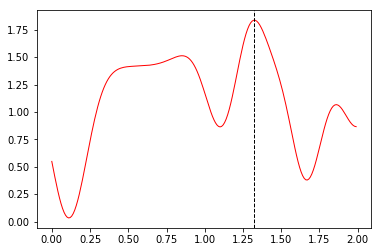

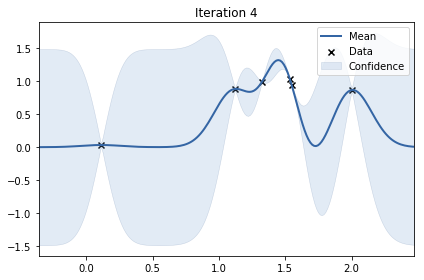

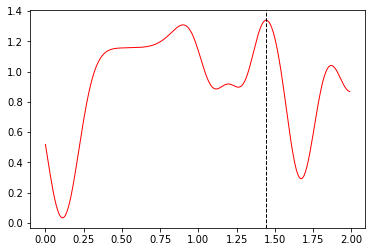

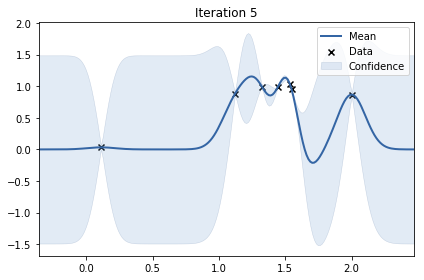

In [316]:
def sample(x):
    return np.sin(x) + np.random.randn(*x.shape) * 0.05

kernel = GPy.kern.RBF(input_dim=1, variance=1., lengthscale=1.)

bo(sample, kernel, bounds=np.array([[0,2]]), plot=True, n_iter=5)

- implement GP-UCB (how to bayesian update GP?)
- understand and implement bayesian linear model
- DIRECT to optimize u.

Questions
---------

- how many point to begin with? (two?)